In [300]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

In [301]:
#!/bin/bash
!kaggle datasets download prachi13/customer-analytics -p ./data

Dataset URL: https://www.kaggle.com/datasets/prachi13/customer-analytics
License(s): other
customer-analytics.zip: Skipping, found more recently modified local copy (use --force to force download)


In [302]:
import os

HOME = os.getcwd()
# 압축 파일의 위치
zipPath = os.path.join(HOME, 'data','customer-analytics.zip')
# 압축 해제 할 위치
targetPath = os.path.join(HOME, 'data')

In [303]:
from zipfile import ZipFile

with ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(targetPath)

In [304]:
trainPath = os.path.join(targetPath, 'Train.csv')
df = pd.read_csv(trainPath)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [306]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [307]:
TARGET = 'Reached.on.Time_Y.N'
target = 'Reached.on.Time_Y.N'

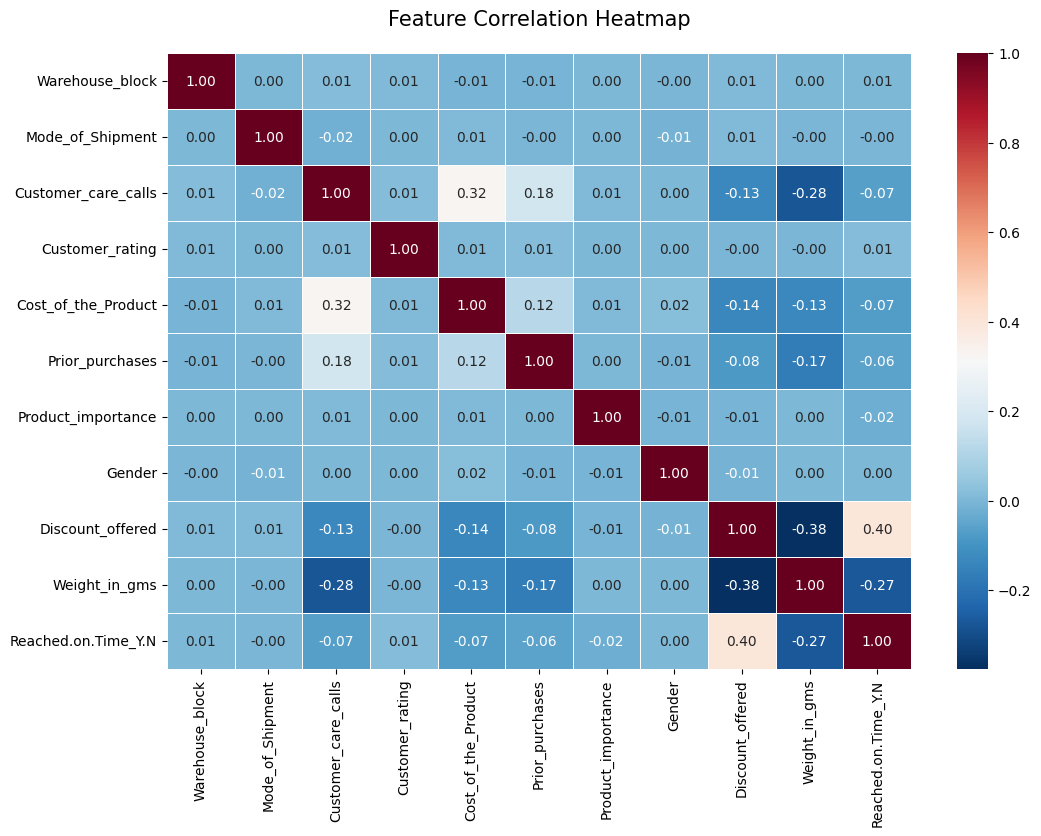

In [308]:
data = df.copy().drop(columns=['ID'])

# 범주형 변수 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
object_cols = data.select_dtypes(include=['object']).columns

for col in object_cols:
    data[col] = le.fit_transform(data[col])

# 히트맵 시각화
plt.figure(figsize=(12, 8)) 
sns.heatmap(data.corr(), annot=True, fmt='.2f', 
            cmap='RdBu_r', 
            linewidths=0.5, annot_kws={'size': 10})
plt.title('Feature Correlation Heatmap', fontsize=15, pad=20)
plt.show()

In [309]:
# 1. stratify 옵션을 써서 정답(Reached.on.Time_Y.N) 비율을 유지하며 8:2로 나눕니다.
# 이 함수는 내부적으로 데이터를 랜덤하게 섞어주기 때문에 sample을 따로 안 써도 됩니다.
part1, part2 = train_test_split(df, 
                                test_size=0.2, 
                                random_state=42, 
                                stratify=df['Reached.on.Time_Y.N'])

# 2. 각각 파일로 저장
part1.to_csv('data/train_df.csv', index=False)
part2.to_csv('data/test_df.csv', index=False)

print("데이터 분할 및 저장 완료!")
print(f"학습용: {part1.shape}, 테스트용: {part2.shape}")

데이터 분할 및 저장 완료!
학습용: (8799, 12), 테스트용: (2200, 12)


In [310]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')
train_df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,7921,D,Road,4,1,261,2,medium,F,9,4158,0
1,1530,F,Ship,3,3,162,2,low,F,26,1659,1
2,10522,B,Ship,3,2,221,2,medium,M,9,4466,0
3,9559,D,Ship,3,5,157,4,medium,F,2,4640,0
4,969,A,Flight,2,5,272,2,low,M,24,3638,1


In [311]:
# target 데이터의 분포가 6:4로 비슷하게 이루어져 있음
print(f"배송 지연 확률: {train_df['Reached.on.Time_Y.N'].mean() * 100:.2f}%")

배송 지연 확률: 59.67%


| 컬럼명 (Column Name) | 설명 (Description) | 구분/범위 (Value Range) | 비고 (Additional Notes) |
| :--- | :--- | :--- | :--- |
| **ID** | 고객 고유 번호 | 숫자 (Numeric) | 인덱스. 정보 가치 없음|
| **Warehouse block** | 창고 구역 | A, B, C, D, E | 대규모 창고 내 구역 구분 |
| **Mode of shipment** | 배송 수단 | Ship, Flight, Road | 선박, 항공, 육로 배송 |
| **Customer care calls** | 고객 센터 문의 횟수 | 숫자 (Numeric) | 배송 관련 문의 전화 건수 |
| **Customer rating** | 고객 만족도 평점 | 1(낮음) ~ 5(높음) | 배송에 대한 만족도가 아닐수 있음에 주의 |
| **Cost of the product** | 제품 가격 | US 달러 ($) | 해당 제품의 판매가 |
| **Prior purchases** | 이전 구매 횟수 | 숫자 (Numeric) | 해당 고객의 과거 구매 이력 |
| **Product importance** | 제품 중요도 | low, medium, high | 중요도의 기준이 무엇인지 확인 불가 |
| **Gender** | 성별 | Male, Female |  |
| **Discount offered** | 할인액 | 1~65의 정수 | 할인 금액. 할인율과 다를것으로 추측 |
| **Weight in gms** | 제품 무게 | 그램 (g) | 제품의 실제 무게 |
| **Reached on time** | **정시 도착 여부** | 0: 정시, 1: 지연 | **타겟 변수 (Target Variable)** |

#### 특성 분류
범주형과 수치형의 분리

In [312]:
def split_feature_types(df, threshold=10):
    """
    ID를 제외하고 범주형과 수치형을 분리합니다.
    수치형 중에서도 고유값(unique) 개수가 threshold 이하이면 범주형으로 간주합니다.
    """
    temp_df = df.copy()
    if 'ID' in temp_df.columns:
        temp_df = temp_df.drop(columns=['ID'])
        
    # 타겟 제외
    target_name = 'Reached.on.Time_Y.N'
    features = [col for col in temp_df.columns if col != target_name]
    
    cat_cols = []
    num_cols = []
    
    for col in features:
        # 1. 데이터 타입이 object/category거나, 고유값 개수가 적은 경우 범주형으로 분류
        if temp_df[col].dtype in ['object', 'category'] or temp_df[col].nunique() <= threshold:
            cat_cols.append(col)
        # 2. 그 외에는 수치형으로 분류
        else:
            num_cols.append(col)

    print(f'범주형:{cat_cols}')
    print(f'숫자형:{num_cols}')
    return cat_cols, num_cols

In [313]:
cat_cols, num_cols = split_feature_types(train_df)

범주형:['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Prior_purchases', 'Product_importance', 'Gender']
숫자형:['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']


### 시각화 함수 정의

In [314]:
# 범주형 특성의 시각화

target = 'Reached.on.Time_Y.N'

def plot_categorical_analysis(df, features, target):
    """
    범주형 특성 리스트를 받아 왼쪽에는 빈도 분포(Count), 
    오른쪽에는 타겟 지연율(Rate)을 나란히 시각화합니다.
    """
    num_features = len(features)
    # 한 행에 한 특성씩(왼쪽/오른쪽 두 개 그래프) 배치하므로 rows는 특성 개수와 같습니다.
    rows = num_features 
    
    plt.figure(figsize=(10, rows * 3))
    plt.suptitle('Categorical Feature Analysis: Distribution vs Delay Rate', fontsize=14, fontweight='bold', y=1.01)

    for i, col in enumerate(features):
        
        order = sorted(df[col].unique())
        
        # --- 왼쪽: 빈도 분포 (Count Plot) ---
        plt.subplot(rows, 2, i * 2 + 1)
        sns.countplot(x=col, data=df, order=order, palette='Pastel1', hue=col, legend=False)
        plt.title(f'{col} Distribution', fontsize=10)
        plt.xlabel('') # 가독성을 위해 x축 레이블 생략 가능
       
        # --- 오른쪽: 지연율 (Delay Rate Bar Plot) ---
        plt.subplot(rows, 2, i * 2 + 2)
        # 지연율 계산
        ax = sns.barplot(
            x=col, y=target, data=df, order=order, 
            palette='viridis', hue=col, legend=False, errorbar=None
        )
        
        # 전체 평균 지연율 기준선
        avg_rate = df[target].mean()
        ax.axhline(avg_rate, color='red', linestyle='--', alpha=0.6)
        
        # 수치 표시 (%)
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.1%}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', fontsize=9, xytext=(0, 5),
                        textcoords='offset points')

        plt.title(f'{col} Delay Rate', fontsize=10)
        plt.xlabel('')
        plt.ylabel('')
        plt.ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

In [315]:
# 수치형 특성의 시각화

def plot_numeric_analysis(df, features, target):
    """
    수치형 특성 리스트를 받아 한 행에 KDE, Boxplot, Histogram+KDE를 시각화합니다.
    """
    num_features = len(features)
    # 한 행에 3개씩 배치
    plt.figure(figsize=(18, num_features * 4))
    plt.suptitle('Numerical Feature Analysis: KDE vs Boxplot vs Histogram', fontsize=18, fontweight='bold', y=1.02)

    for i, col in enumerate(features):
        # 1. KDE Plot: 두 그룹의 밀도 곡선 비교
        plt.subplot(num_features, 3, i*3 + 1)
        sns.kdeplot(data=df, x=col, hue=target, fill=True, common_norm=False, palette='viridis', alpha=0.5)
        plt.title(f'{col} - Density Curve', fontsize=12)

        # 2. Boxplot: 중앙값 및 이상치 확인
        plt.subplot(num_features, 3, i*3 + 2)
        sns.boxplot(data=df, x=target, y=col, hue=target, palette='viridis', legend=False)
        plt.title(f'{col} - Outliers & Range', fontsize=12)
        
        # 3. Histogram + KDE: 실제 데이터 빈도와 곡선 결합
        plt.subplot(num_features, 3, i*3 + 3)
        sns.histplot(data=df, x=col, hue=target, kde=True, element="step", palette='viridis', alpha=0.3)
        plt.title(f'{col} - Histogram (Step)', fontsize=12)

    plt.tight_layout()
    plt.show()

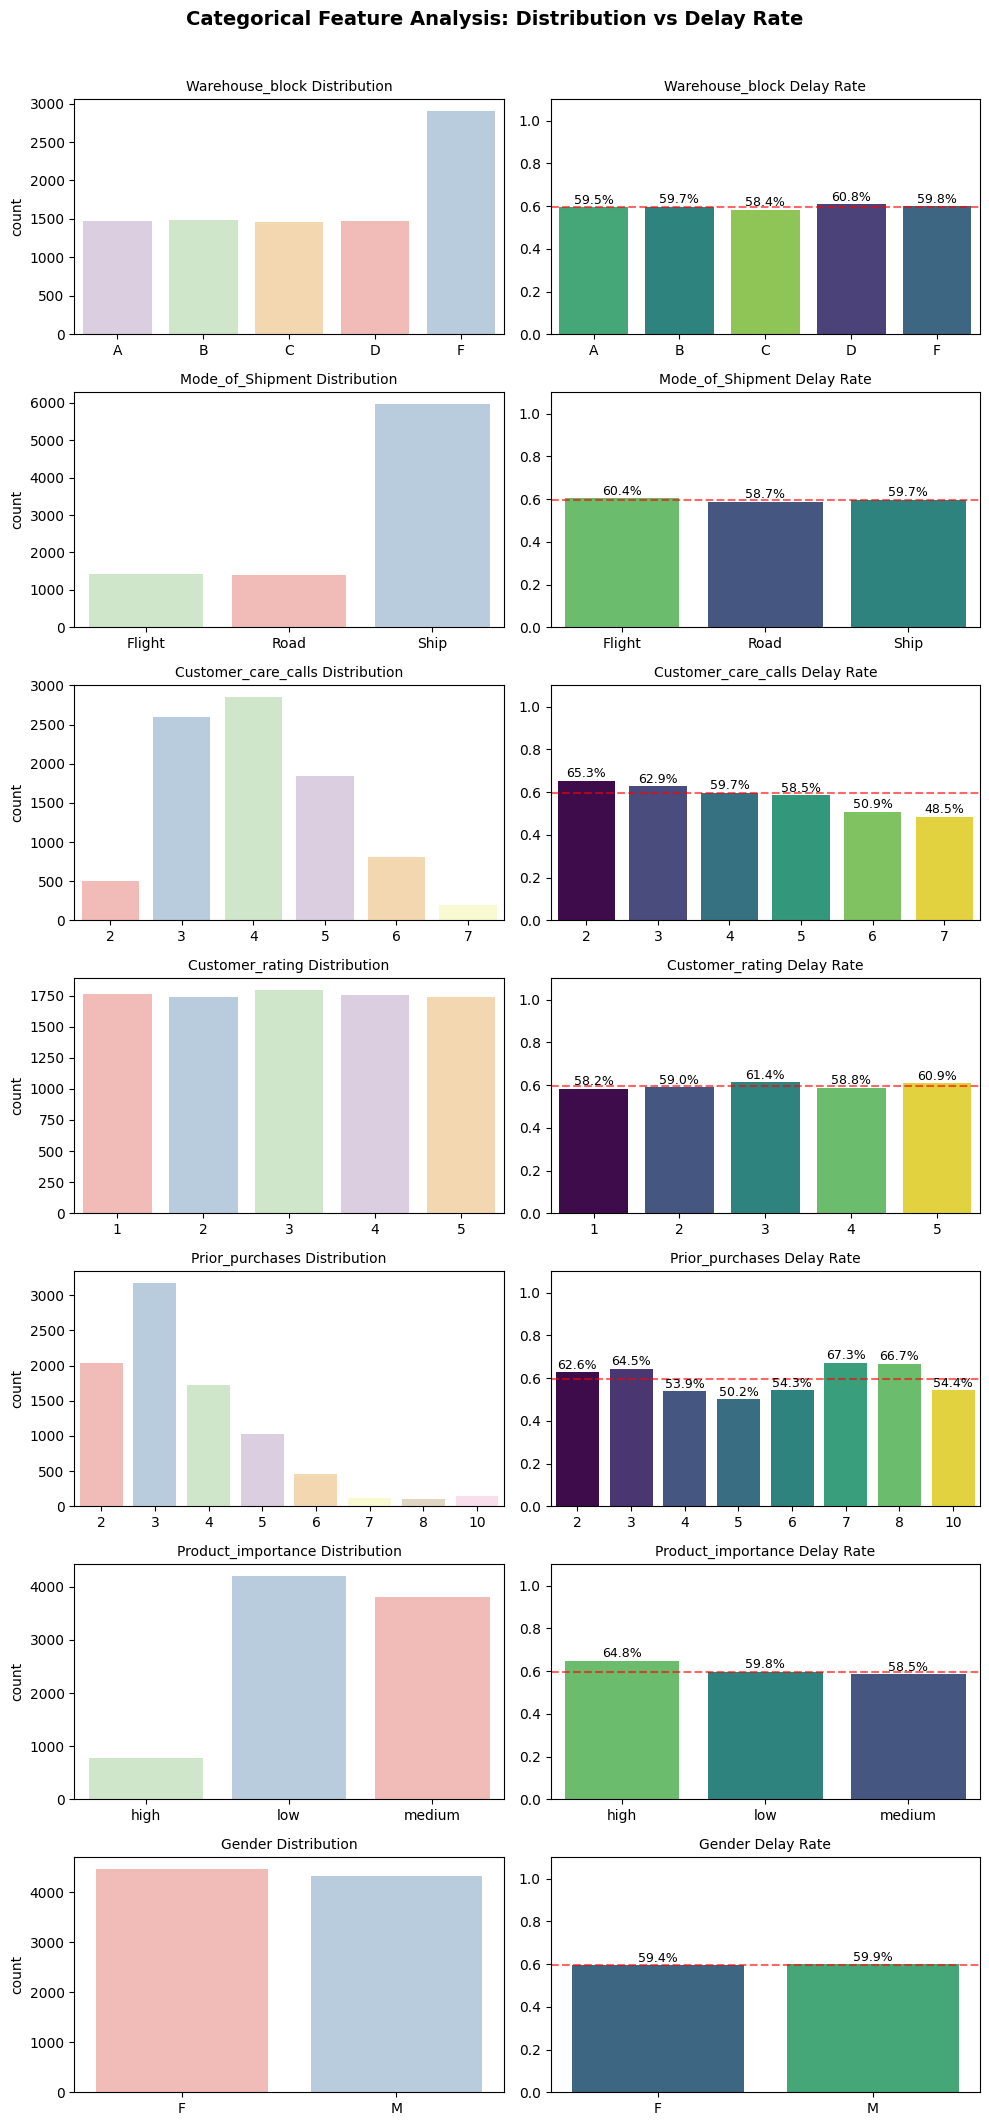

In [316]:
plot_categorical_analysis(train_df, cat_cols, target)

1. Warehouse_block의 화물 분량이 f가 다른 부분의 2배
	1. 지연율 차이 미미
2. Mode_of_Shipment은 Ship에 집중
	1. 지연율 차이 미미
3. Customer_care_calls는 최소 2
	1. 많아질수록 지연율 떨어짐
4. Customer_rating은 분포가 고르다
	1. 지연율 차이도 미미
5. Prior_purchases는 6 이후 극소
	1. 지연율은 4,5,6에서 감소
6. Product_importance는 High에서 오히려 높은 지연율
7. Gender는 영향 없음

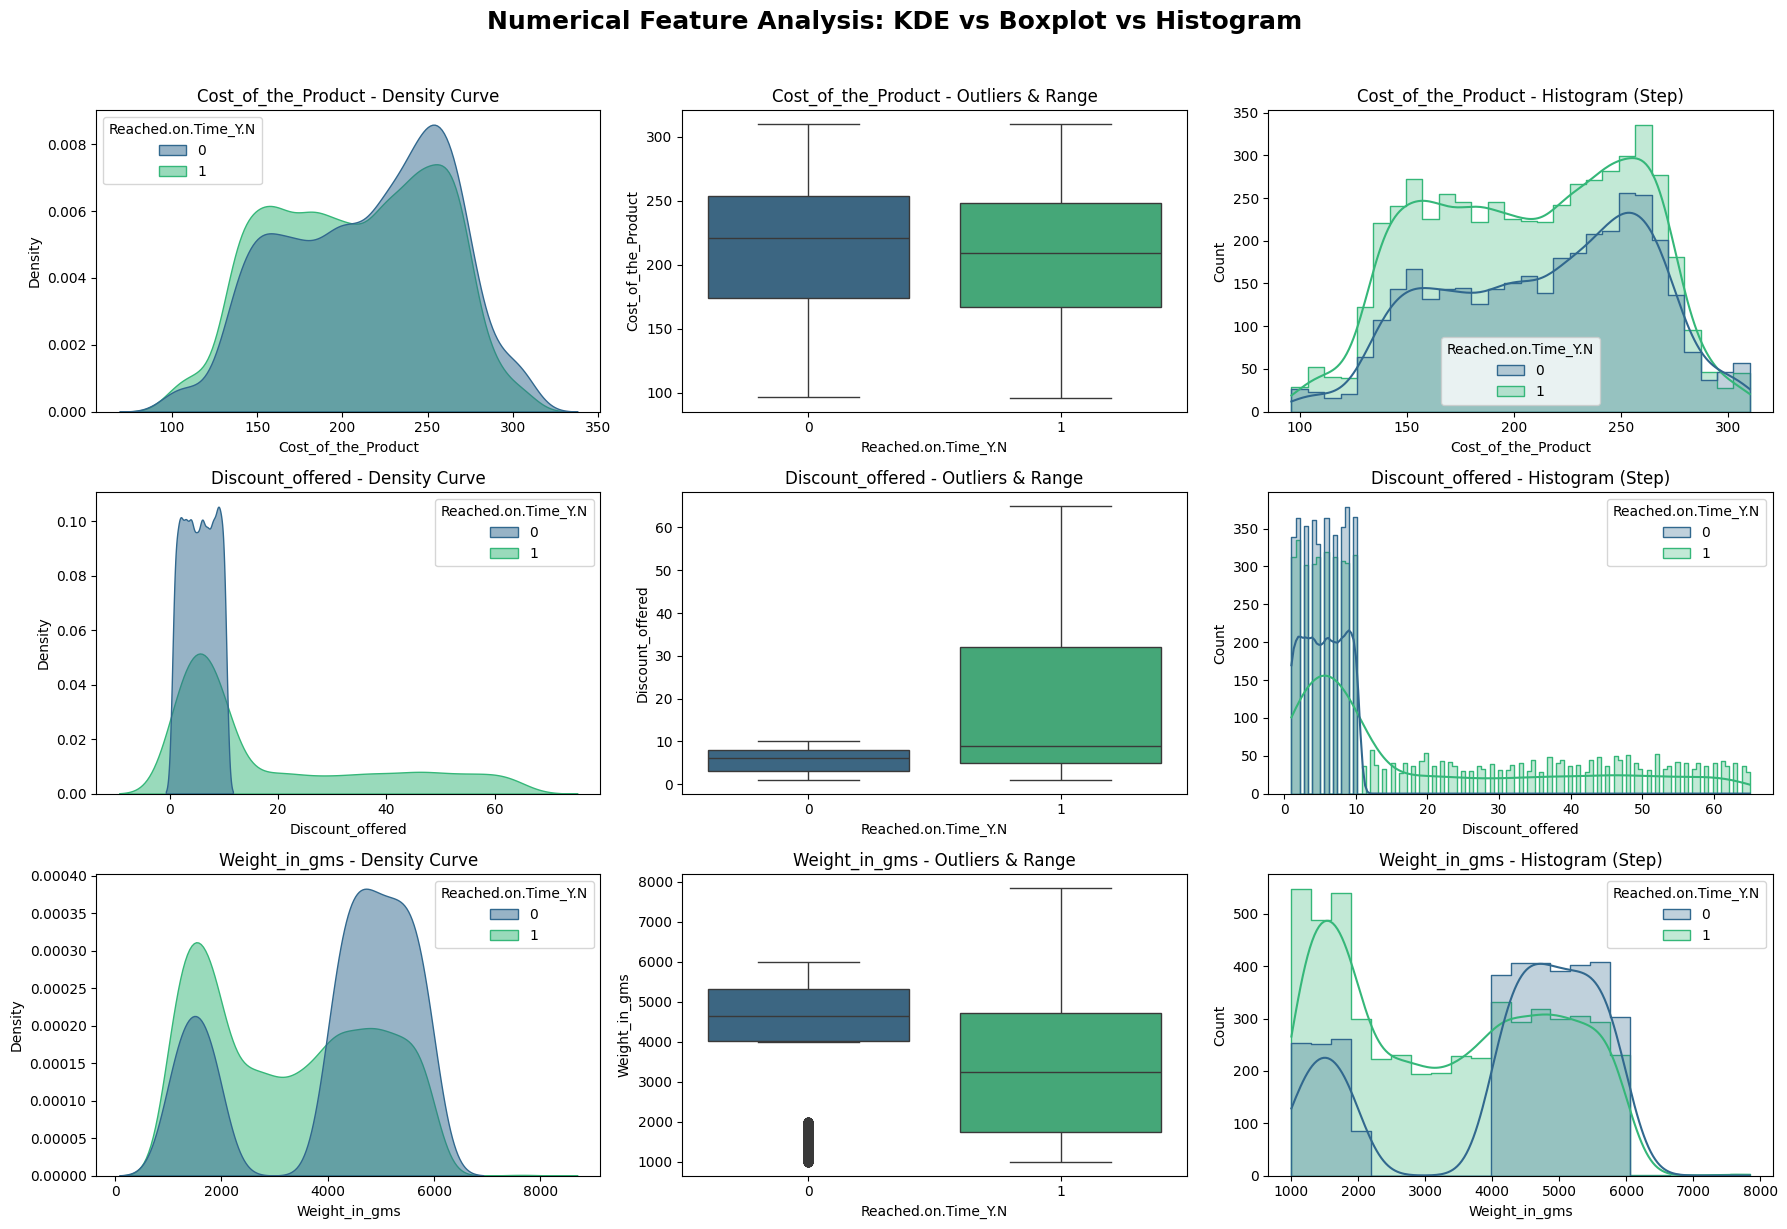

In [317]:
plot_numeric_analysis(train_df, num_cols, target)

8. Cost_of_the_product는 큰 영향 없는듯 보인다
9. Discount_offered는 10 초과는 지연
10. Weight_in_gms는 구간에 따른 지연율 차이

## EDA

### 특성간 비교 함수 정의

In [318]:
# 범주형 특성과의 관계 분석 함수

def summarize_categorical_with_plots(df, group_col, target_features, threshold=5.0):
    """
    각 창고별 비율과 전체 비율(Overall)을 비교하여 
    차이가 threshold(%p) 이상인 경우에만 표를 출력합니다.
    """
    filtered_features = [col for col in target_features if col != group_col]
    
    for col in filtered_features:
        # 1. 그룹별 빈도 및 비율 계산
        count_table = pd.crosstab(df[group_col], df[col])
        percent_table = pd.crosstab(df[group_col], df[col], normalize='index') * 100
        
        # 2. 전체 데이터(Overall) 비율 및 빈도 계산
        overall_counts = df[col].value_counts().reindex(count_table.columns)
        overall_percents = (df[col].value_counts(normalize=True) * 100).reindex(count_table.columns)
        
        # 3. 이상치 여부 판단 (어떤 그룹이라도 전체 평균과 threshold 이상 차이가 나는가?)
        is_outlier = False
        for category in overall_percents.index:
            diff = (percent_table[category] - overall_percents[category]).abs()
            if diff.max() >= threshold:
                is_outlier = True
                break
        
        # 4. 결과 출력
        if is_outlier:
            print(f"\n[🚨 이상치 발견] '{col}' 특성은 {group_col}별로 유의미한 차이가 있습니다.")
            
            # 5. 빈도와 비율을 합친 요약 테이블 생성
            summary_table = count_table.copy().astype(str)
            for row in count_table.index:
                for c in count_table.columns:
                    summary_table.loc[row, c] = f"{count_table.loc[row, c]} ({percent_table.loc[row, c]:.1f}%)"
            
            # 6. Overall(전체 평균) 행 추가
            overall_row = []
            for c in count_table.columns:
                overall_row.append(f"{overall_counts[c]} ({overall_percents[c]:.1f}%)")
            
            summary_table.loc['Overall'] = overall_row
            
            display(summary_table)


            # --- [시각화 데이터 준비] ---
            # 표와 동일한 구조를 위해 Overall을 포함한 Wide format 생성
            plot_df_wide = percent_table.copy()
            plot_df_wide.loc['Overall'] = overall_percents
            
            # 그래프용 Long format 변환
            plot_df_long = plot_df_wide.reset_index().melt(id_vars=group_col, var_name=col, value_name='Percentage')

            # --- [그래프 그리기] ---
            plt.figure(figsize=(10, 5))
            
            # 범례 순서를 표의 컬럼 순서와 동일하게 고정
            category_order = list(count_table.columns)
            
            ax = sns.barplot(
                data=plot_df_long, y=group_col, x='Percentage', hue=col, hue_order=category_order, palette='viridis' )
            
            # 막대 옆에 % 수치 표시
            for p in ax.patches:
                width = p.get_width()
                if width > 0:
                    ax.annotate(f' {width:.1f}%', 
                                (width, p.get_y() + p.get_height() / 2.), 
                                ha='left', va='center', fontsize=9, fontweight='bold', xytext=(3, 0), textcoords='offset points')

            plt.title(f'Distribution of {col} by {group_col}', fontsize=14, pad=20)
            plt.xlabel('Percentage (%)')
            plt.ylabel(group_col)
            plt.xlim(0, plot_df_long['Percentage'].max() * 1.2) # 수치 표시 공간 확보
            plt.legend(title=col, bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.grid(axis='x', linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            
        else:
            print(f"[✅ 이상치 없음] '{col}': 모든 {group_col}에서 고른 분포를 보입니다.")

In [319]:
# 수치형 특성과의 관계 분석 함수

def summarize_numeric_with_plots(df, group_col, target_features, threshold=0.1):
    """
    수치형 특성의 그룹별 통계량과 전체 분포를 비교 시각화합니다.
    """
    for col in target_features:
        if col == group_col: continue
        
        # 1. 통계량 계산
        group_stats = df.groupby(group_col)[col].describe()
        overall_stats = df[col].describe()
        
        # 2. 이상치 판단 (그룹 평균이 전체 평균과 threshold 이상 차이 나는지)
        mean_diff = (group_stats['mean'] - overall_stats['mean']).abs() / overall_stats['mean']
        
        if mean_diff.max() >= threshold:
            print(f"\n[🚨 차이 발견] '{col}' 특성은 {group_col}별로 평균 차이가 있습니다.")
            display(group_stats)

            # --- [시각화 시작] ---
            plt.figure(figsize=(12, 6))
            
            # (1) Box Plot 그리기
            ax = sns.boxplot(data=df, x=group_col, y=col, hue=group_col, palette='viridis', legend=False, showmeans=True,
                             meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
            
            # (2) 전체 평균(Overall Mean) 수평선 추가
            plt.axhline(overall_stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Overall Mean: {overall_stats["mean"]:.2f}')
            
            # (3) 각 그룹별 평균값을 텍스트로 표시
            means = df.groupby(group_col)[col].mean()
            for i, mean in enumerate(means):
                ax.annotate(f'{mean:.2f}', xy=(i, mean), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=10, fontweight='bold', color='blue')

            plt.title(f'Comparison: {col} Distribution by {group_col}', fontsize=15)
            plt.legend(loc='upper right')
            plt.grid(axis='y', linestyle=':', alpha=0.7)
            plt.show()
        else:
            print(f"[✅ 통과] '{col}': 그룹별 평균 차이가 미미합니다.")

In [320]:
print(cat_cols)
print(num_cols)

['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Prior_purchases', 'Product_importance', 'Gender']
['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']


In [321]:
# 2, 7의 데이터가 너무 적어 (2,3), 4, 5, (6,7)의 4개 그룹으로 치환
train_df['Customer_care_calls'].value_counts()

Customer_care_calls
4    2859
3    2596
5    1838
6     808
2     504
7     194
Name: count, dtype: int64

In [322]:
train_df.loc[train_df['Customer_care_calls'] >= 6, 'Customer_care_calls'] = 6
train_df.loc[train_df['Customer_care_calls'] <= 3, 'Customer_care_calls'] = 3

In [323]:
train_df['Customer_care_calls'].value_counts()

Customer_care_calls
3    3100
4    2859
5    1838
6    1002
Name: count, dtype: int64

In [324]:
# 6 이후의 데이터가 너무 적어 6으로 통합
train_df['Prior_purchases'].value_counts()

Prior_purchases
3     3182
2     2042
4     1723
5     1027
6      460
10     147
7      113
8      105
Name: count, dtype: int64

In [325]:
train_df.loc[train_df['Prior_purchases'] >= 6, 'Prior_purchases'] = 6

In [326]:
train_df['Prior_purchases'].value_counts()

Prior_purchases
3    3182
2    2042
4    1723
5    1027
6     825
Name: count, dtype: int64

In [327]:
#importance_map = {'low': 0, 'medium': 1, 'high': 2}
#train_df['Product_importance'] = train_df['Product_importance'].map(importance_map)

#### 1. Warehouse_block


In [328]:
summarize_categorical_with_plots(train_df, 'Warehouse_block', cat_cols, threshold=5.0)

[✅ 이상치 없음] 'Mode_of_Shipment': 모든 Warehouse_block에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_care_calls': 모든 Warehouse_block에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_rating': 모든 Warehouse_block에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Prior_purchases': 모든 Warehouse_block에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Product_importance': 모든 Warehouse_block에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Gender': 모든 Warehouse_block에서 고른 분포를 보입니다.


In [329]:
summarize_numeric_with_plots(train_df, 'Warehouse_block', num_cols, threshold=0.1)

[✅ 통과] 'Cost_of_the_Product': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Discount_offered': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Weight_in_gms': 그룹별 평균 차이가 미미합니다.


#### 2. Mode_of_Shipment

In [330]:
summarize_categorical_with_plots(train_df, 'Mode_of_Shipment', cat_cols, threshold=5.0)

[✅ 이상치 없음] 'Warehouse_block': 모든 Mode_of_Shipment에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_care_calls': 모든 Mode_of_Shipment에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_rating': 모든 Mode_of_Shipment에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Prior_purchases': 모든 Mode_of_Shipment에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Product_importance': 모든 Mode_of_Shipment에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Gender': 모든 Mode_of_Shipment에서 고른 분포를 보입니다.


In [331]:
summarize_numeric_with_plots(train_df, 'Mode_of_Shipment', num_cols, threshold=0.1)

[✅ 통과] 'Cost_of_the_Product': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Discount_offered': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Weight_in_gms': 그룹별 평균 차이가 미미합니다.


### 3. Customer_care_calls

In [332]:
train_df['Customer_care_calls'].value_counts()

Customer_care_calls
3    3100
4    2859
5    1838
6    1002
Name: count, dtype: int64

[✅ 이상치 없음] 'Warehouse_block': 모든 Customer_care_calls에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Mode_of_Shipment': 모든 Customer_care_calls에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_rating': 모든 Customer_care_calls에서 고른 분포를 보입니다.

[🚨 이상치 발견] 'Prior_purchases' 특성은 Customer_care_calls별로 유의미한 차이가 있습니다.


Prior_purchases,2,3,4,5,6
Customer_care_calls,,,,,
3,910 (29.4%),1370 (44.2%),424 (13.7%),132 (4.3%),264 (8.5%)
4,731 (25.6%),1184 (41.4%),351 (12.3%),323 (11.3%),270 (9.4%)
5,366 (19.9%),548 (29.8%),279 (15.2%),425 (23.1%),220 (12.0%)
6,35 (3.5%),80 (8.0%),669 (66.8%),147 (14.7%),71 (7.1%)
Overall,2042 (23.2%),3182 (36.2%),1723 (19.6%),1027 (11.7%),825 (9.4%)


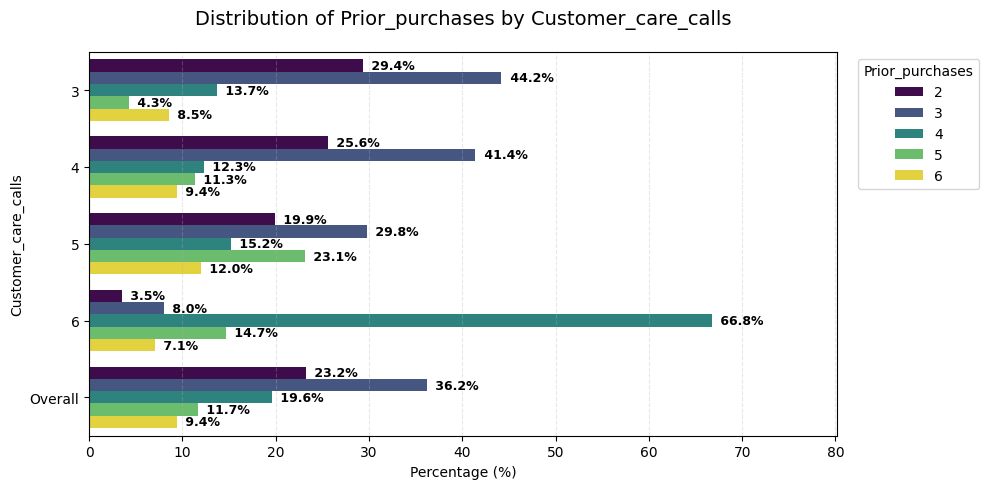


[🚨 이상치 발견] 'Product_importance' 특성은 Customer_care_calls별로 유의미한 차이가 있습니다.


Product_importance,high,low,medium
Customer_care_calls,,,
3,334 (10.8%),1395 (45.0%),1371 (44.2%)
4,225 (7.9%),1370 (47.9%),1264 (44.2%)
5,156 (8.5%),892 (48.5%),790 (43.0%)
6,53 (5.3%),557 (55.6%),392 (39.1%)
Overall,768 (8.7%),4214 (47.9%),3817 (43.4%)


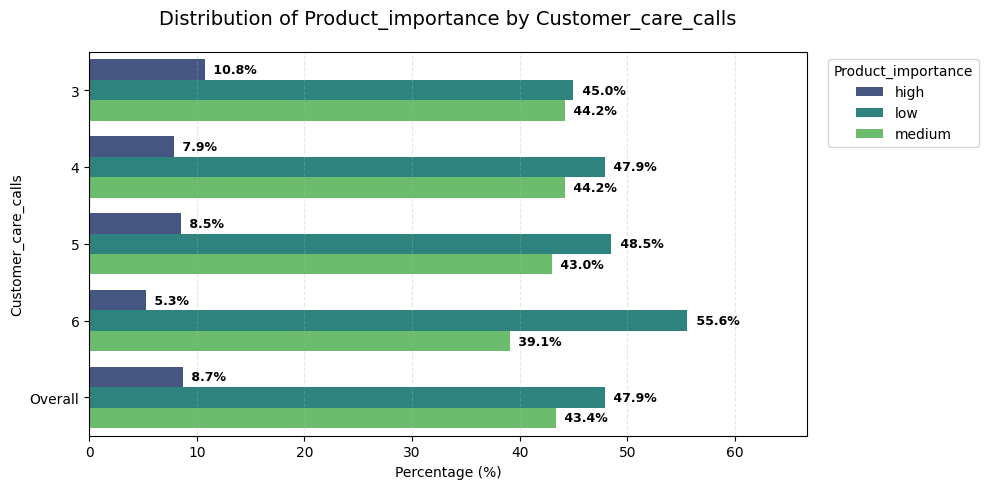

[✅ 이상치 없음] 'Gender': 모든 Customer_care_calls에서 고른 분포를 보입니다.


In [333]:
summarize_categorical_with_plots(train_df, 'Customer_care_calls', cat_cols, threshold=5.0)

'Prior_purchases'와 'Customer_care_calls'

구매 4회 고객의 전화문의 횟수는 6회가 가장 많음: 증가하다 감소하는 그래프 <br>
    가설1: 구매횟수 대비 전화 문의를 많이 한 사람은 배송 지연의 확률이 높은가? <br>
    가설2: 구매 4번째까지는 배송 지연에 화가나 문의를 하지만, 그 이후의 구매에는 기대가 떨어져 문의를 덜 하는가? -> 지연율에 영향 없음

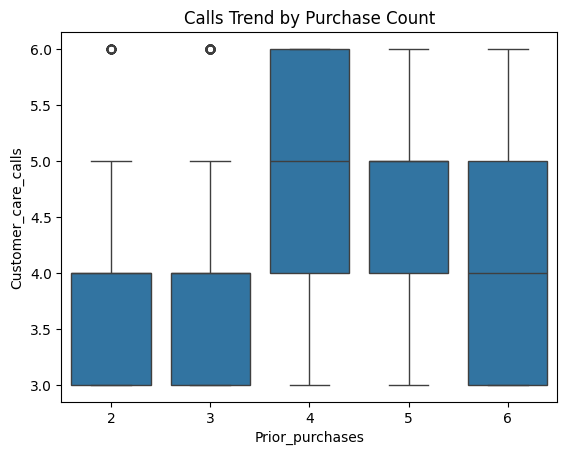

In [334]:
# 구매 횟수별 전화 횟수 추이 (Boxplot)
sns.boxplot(x='Prior_purchases', y='Customer_care_calls', data=train_df)
plt.title('Calls Trend by Purchase Count')
plt.show()

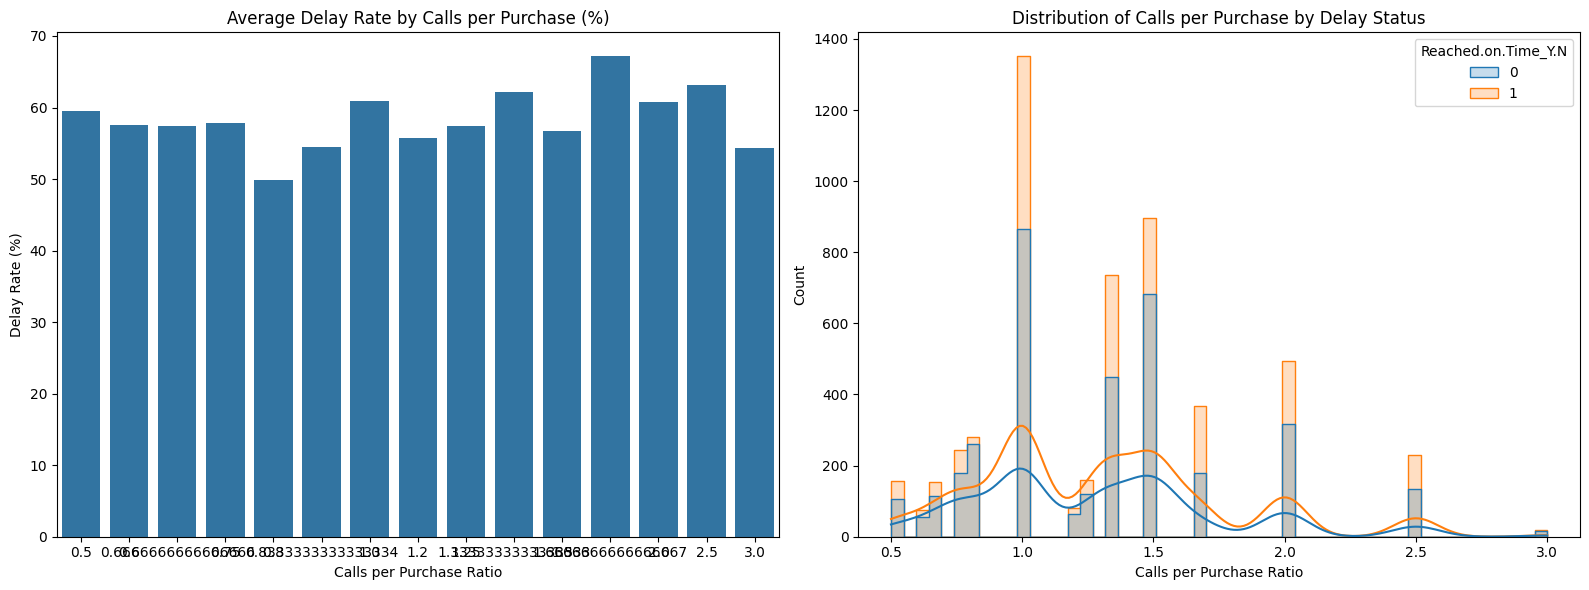

In [335]:
train_df['Calls_per_Purchase'] = train_df['Customer_care_calls'] / train_df['Prior_purchases']
# 1. 도화지 준비
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2. [왼쪽] 구매 대비 전화 횟수에 따른 실제 지연율 (수치 데이터를 그래프로)
delay_rate = train_df.groupby('Calls_per_Purchase')[target].mean() * 100
sns.barplot(x=delay_rate.index, y=delay_rate.values, ax=axes[0])
axes[0].set_title('Average Delay Rate by Calls per Purchase (%)')
axes[0].set_xlabel('Calls per Purchase Ratio')
axes[0].set_ylabel('Delay Rate (%)')

# 3. [오른쪽] 히스토플롯
sns.histplot(data=train_df, x='Calls_per_Purchase', hue=target, 
             kde=True, element="step", ax=axes[1])
axes[1].set_title('Distribution of Calls per Purchase by Delay Status')
axes[1].set_xlabel('Calls per Purchase Ratio')

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

Product_importance와 Customer_care_calls

중요도가 높을수록 전화가 적어지는 경향

중요도 high인 경우 지연율이 평균 이상임을 감안하면 이상한 결과

가설1: 중요도는 제품의 중요도가 아닌, 배송 취약성인가? -> 중요도 분석에서 검증

가설2: 전화를 많이 할 수록 중요도를 낮추는가?

-> Product importance: The company has categorized the product in the various parameter such as low, medium, high.

kaggle에는 제품에 대해 회사가 등급을 선정하였다고 설명됨


[🚨 차이 발견] 'Cost_of_the_Product' 특성은 Customer_care_calls별로 평균 차이가 있습니다.


,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,,,,,,,,
3,3100.0,198.072581,45.021721,96.0,160.00,197.0,237.0,310.0
4,2859.0,205.861840,44.537105,96.0,168.00,209.0,245.0,301.0
5,1838.0,214.638738,44.470881,97.0,179.00,225.0,251.0,307.0
6,1002.0,252.222555,49.119107,98.0,242.25,265.0,286.0,310.0


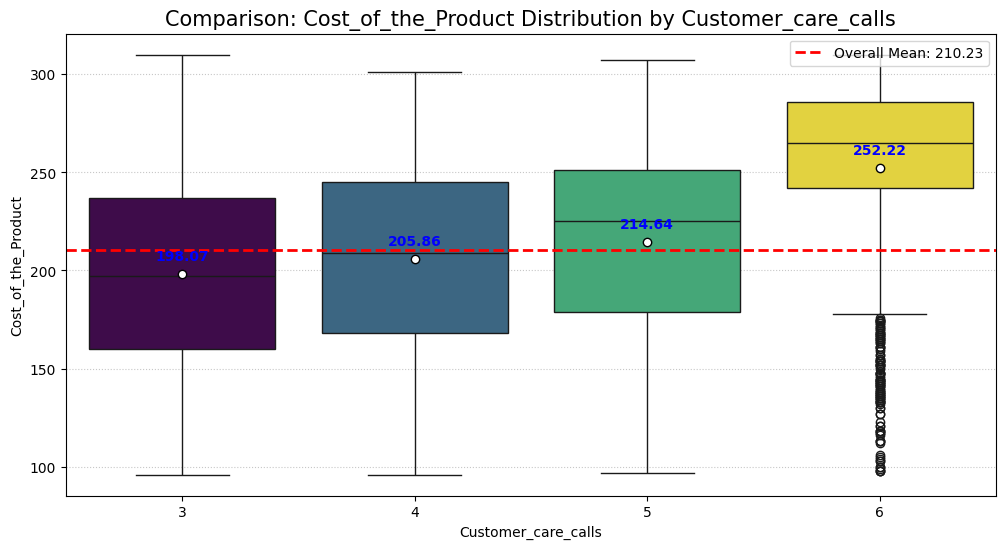


[🚨 차이 발견] 'Discount_offered' 특성은 Customer_care_calls별로 평균 차이가 있습니다.


,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,,,,,,,,
3,3100.0,15.415484,17.528522,1.0,4.0,8.0,19.0,65.0
4,2859.0,13.380553,16.102605,1.0,4.0,7.0,11.0,65.0
5,1838.0,12.633841,15.638064,1.0,4.0,7.0,10.0,65.0
6,1002.0,8.335329,10.579575,1.0,3.0,6.0,9.0,65.0


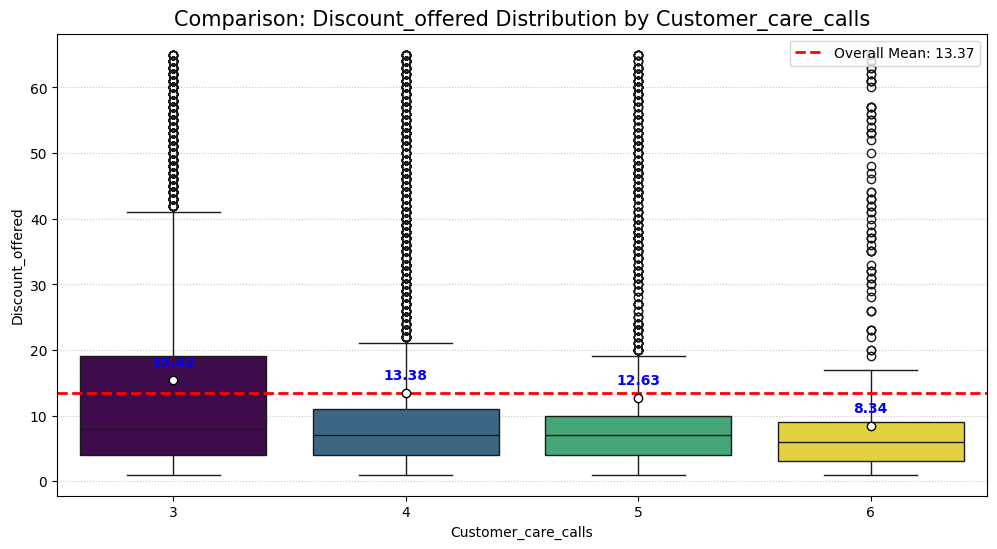


[🚨 차이 발견] 'Weight_in_gms' 특성은 Customer_care_calls별로 평균 차이가 있습니다.


,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,,,,,,,,
3,3100.0,3969.918387,1498.540805,1004.0,2727.00,4372.5,5184.25,7846.0
4,2859.0,3844.457503,1568.115869,1001.0,2270.50,4331.0,5148.50,6000.0
5,1838.0,3468.522307,1653.171112,1001.0,1730.50,3917.0,4946.00,6000.0
6,1002.0,2273.432136,1450.641967,1003.0,1303.25,1660.0,2334.00,5992.0


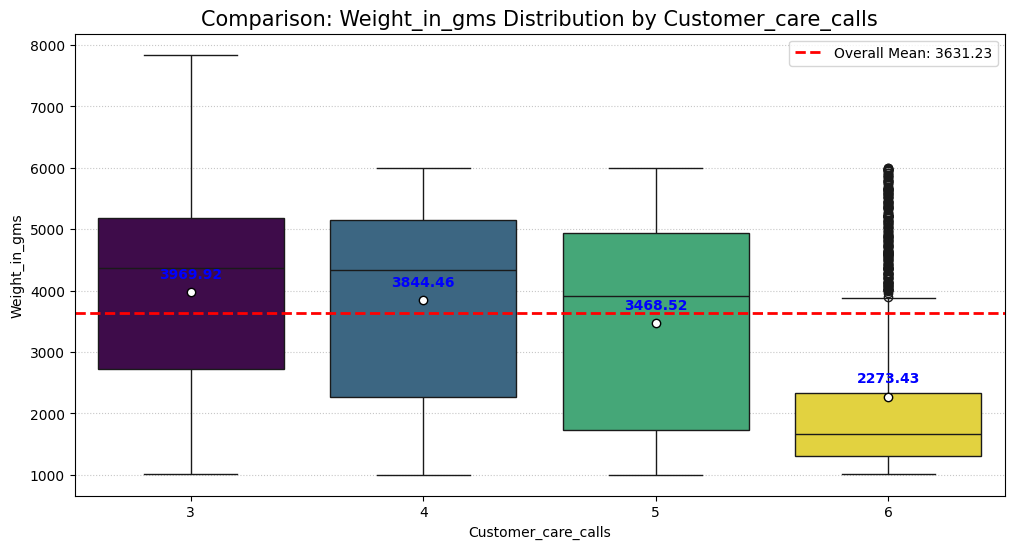

In [336]:
summarize_numeric_with_plots(train_df, 'Customer_care_calls', num_cols, threshold=0.1)

가격이 높아질 수록 전화 횟수가 증가. 할인액이 낮을수록 전화 횟수가 증가 -> 가격에 민감한 소비자의 특성?

무게가 낮을수록 전화 횟수가 증가 -> 가설 1: 무게가 낮지만 가치가 높은 제품?

무게 대비 가격을 만들고 지연률과의 관계 확인

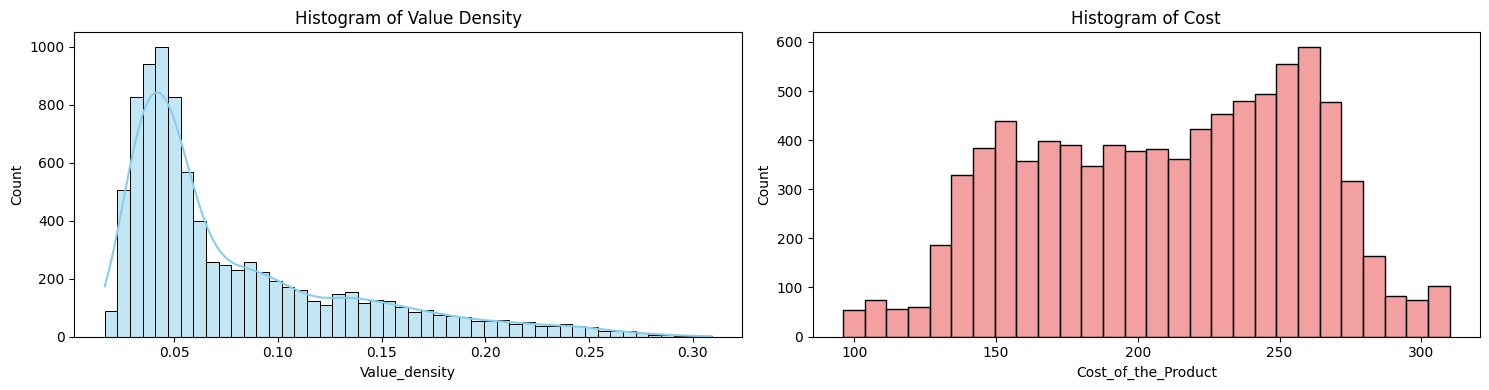

In [351]:
copy_df = train_df.copy()
copy_df['Value_density'] = copy_df['Cost_of_the_Product'] / copy_df['Weight_in_gms']

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# [왼쪽] 히스토그램 + KDE (전체적인 분포 모양)
sns.histplot(copy_df['Value_density'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Histogram of Value Density')

# [오른쪽] 박스플롯 (이상치 및 사분위수 확인)
sns.histplot(x=copy_df['Cost_of_the_Product'], ax=axes[1], color='lightcoral')
axes[1].set_title('Histogram of Cost')

plt.tight_layout()
plt.show()


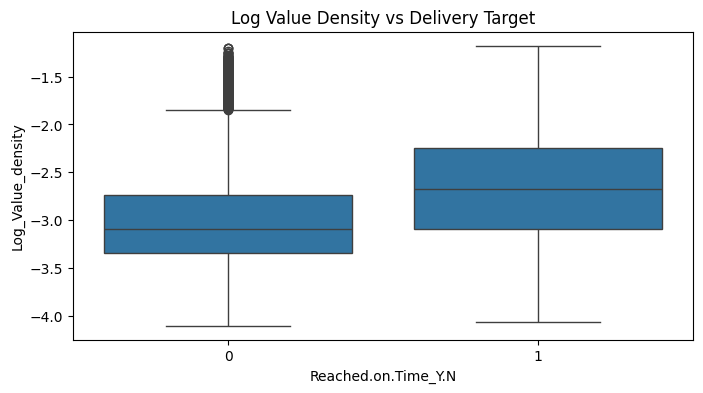

In [352]:
# Value_density의 분포가 편향되었기 때문에 log를 취한다
#유의미한 결과가 나왔음을 알 수 있다.
copy_df['Log_Value_density'] = np.log(copy_df['Value_density'])

plt.figure(figsize=(8, 4))
sns.boxplot(data=copy_df, x=target, y='Log_Value_density')
plt.title('Log Value Density vs Delivery Target')
plt.show()

### 4. Customer_rating

In [353]:
summarize_categorical_with_plots(train_df, 'Customer_rating', cat_cols, threshold=5.0)

[✅ 이상치 없음] 'Warehouse_block': 모든 Customer_rating에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Mode_of_Shipment': 모든 Customer_rating에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_care_calls': 모든 Customer_rating에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Prior_purchases': 모든 Customer_rating에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Product_importance': 모든 Customer_rating에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Gender': 모든 Customer_rating에서 고른 분포를 보입니다.


In [354]:
summarize_numeric_with_plots(train_df, 'Customer_rating', num_cols, threshold=0.1)

[✅ 통과] 'Cost_of_the_Product': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Discount_offered': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Weight_in_gms': 그룹별 평균 차이가 미미합니다.


### 5. Prior_purchases

[✅ 이상치 없음] 'Warehouse_block': 모든 Prior_purchases에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Mode_of_Shipment': 모든 Prior_purchases에서 고른 분포를 보입니다.

[🚨 이상치 발견] 'Customer_care_calls' 특성은 Prior_purchases별로 유의미한 차이가 있습니다.


Customer_care_calls,3,4,5,6
Prior_purchases,,,,
2,910 (44.6%),731 (35.8%),366 (17.9%),35 (1.7%)
3,1370 (43.1%),1184 (37.2%),548 (17.2%),80 (2.5%)
4,424 (24.6%),351 (20.4%),279 (16.2%),669 (38.8%)
5,132 (12.9%),323 (31.5%),425 (41.4%),147 (14.3%)
6,264 (32.0%),270 (32.7%),220 (26.7%),71 (8.6%)
Overall,3100 (35.2%),2859 (32.5%),1838 (20.9%),1002 (11.4%)


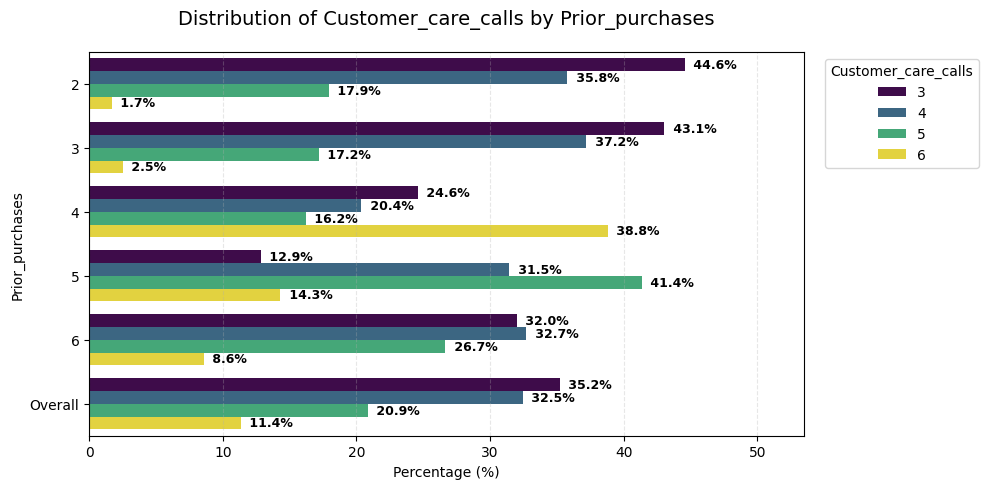

[✅ 이상치 없음] 'Customer_rating': 모든 Prior_purchases에서 고른 분포를 보입니다.

[🚨 이상치 발견] 'Product_importance' 특성은 Prior_purchases별로 유의미한 차이가 있습니다.


Product_importance,high,low,medium
Prior_purchases,,,
2,199 (9.7%),949 (46.5%),894 (43.8%)
3,309 (9.7%),1486 (46.7%),1387 (43.6%)
4,113 (6.6%),887 (51.5%),723 (42.0%)
5,42 (4.1%),574 (55.9%),411 (40.0%)
6,105 (12.7%),318 (38.5%),402 (48.7%)
Overall,768 (8.7%),4214 (47.9%),3817 (43.4%)


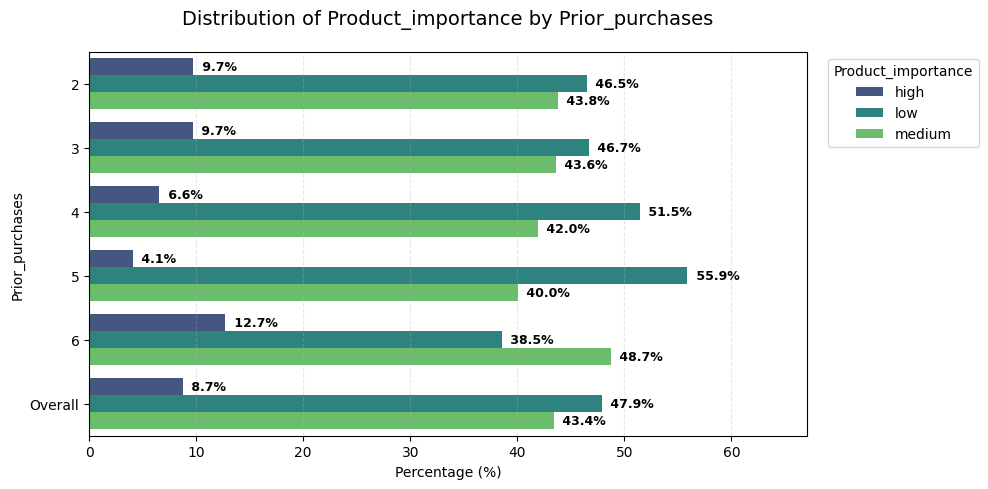

[✅ 이상치 없음] 'Gender': 모든 Prior_purchases에서 고른 분포를 보입니다.


In [355]:
summarize_categorical_with_plots(train_df, 'Prior_purchases', cat_cols, threshold=5.0)

구매횟수 5회까지는 중요도가 점점 낮아지다 6회에는 높아진다.

'Prior_purchases'의 분포 확인 결과 4 이후에 급격한 하락.

가설: 구매경험 ~4회까지의 높은 지연율에 고객들이 이탈. 충성도 높은고객들은 상대적으로 더 높은 중요도의 물건 구매? -> 지연율과 관계 없음

In [356]:
train_df['Prior_purchases'].value_counts()

Prior_purchases
3    3182
2    2042
4    1723
5    1027
6     825
Name: count, dtype: int64

[✅ 통과] 'Cost_of_the_Product': 그룹별 평균 차이가 미미합니다.

[🚨 차이 발견] 'Discount_offered' 특성은 Prior_purchases별로 평균 차이가 있습니다.


,count,mean,std,min,25%,50%,75%,max
Prior_purchases,,,,,,,,
2,2042.0,15.292360,17.313979,1.0,4.0,8.0,20.0,65.0
3,3182.0,15.174104,17.422930,1.0,4.0,7.0,19.0,65.0
4,1723.0,10.647127,13.727382,1.0,3.0,7.0,10.0,65.0
5,1027.0,9.397274,12.121377,1.0,3.0,6.0,9.0,65.0
6,825.0,12.253333,15.314346,1.0,4.0,7.0,10.0,65.0


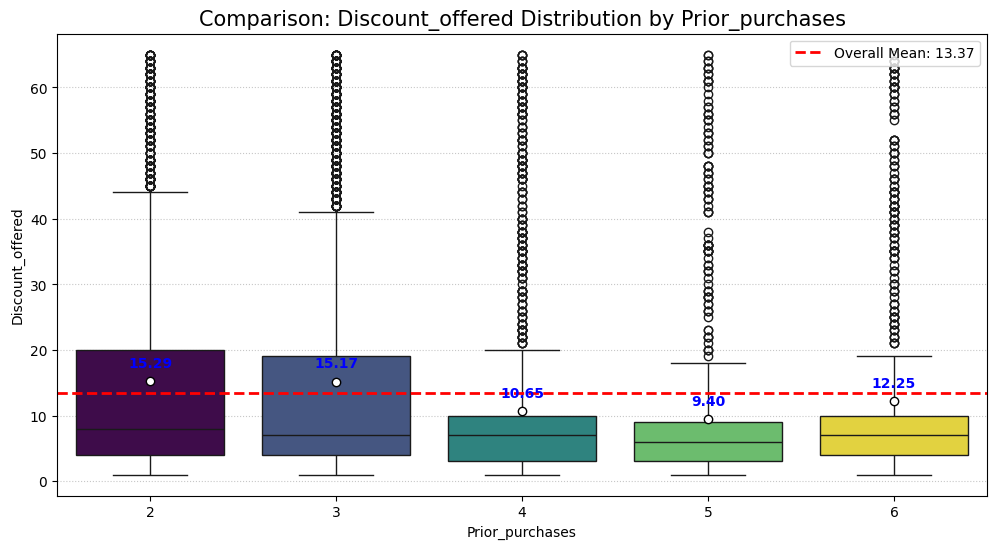


[🚨 차이 발견] 'Weight_in_gms' 특성은 Prior_purchases별로 평균 차이가 있습니다.


,count,mean,std,min,25%,50%,75%,max
Prior_purchases,,,,,,,,
2,2042.0,4011.672870,1451.756663,1001.0,2858.50,4374.5,5190.00,6000.0
3,3182.0,4035.417976,1474.620793,1005.0,2866.25,4427.5,5213.75,7846.0
4,1723.0,3122.888566,1702.390639,1003.0,1535.50,2583.0,4781.00,5989.0
5,1027.0,2462.910419,1544.628663,1001.0,1357.50,1736.0,4056.50,5993.0
6,825.0,3646.656970,1624.899209,1003.0,1861.00,4179.0,5035.00,5995.0


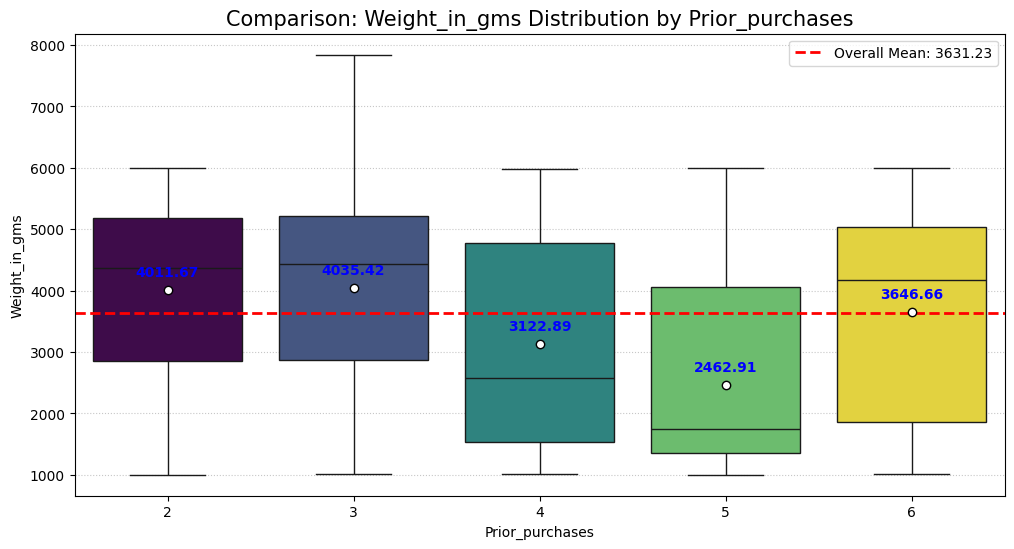

In [357]:
summarize_numeric_with_plots(train_df, 'Prior_purchases', num_cols, threshold=0.1)

가설: 높은 구매횟수는 지연위험이 있는 물품 구매를 회피하는가?
-> 할인액으로 확인시 그런 경향이 보이나, 무게로 확인시 위험 구역인 2000~4000을 피하지 못함

#### 6. Product_importance

[✅ 이상치 없음] 'Warehouse_block': 모든 Product_importance에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Mode_of_Shipment': 모든 Product_importance에서 고른 분포를 보입니다.

[🚨 이상치 발견] 'Customer_care_calls' 특성은 Product_importance별로 유의미한 차이가 있습니다.


Customer_care_calls,3,4,5,6
Product_importance,,,,
high,334 (43.5%),225 (29.3%),156 (20.3%),53 (6.9%)
low,1395 (33.1%),1370 (32.5%),892 (21.2%),557 (13.2%)
medium,1371 (35.9%),1264 (33.1%),790 (20.7%),392 (10.3%)
Overall,3100 (35.2%),2859 (32.5%),1838 (20.9%),1002 (11.4%)


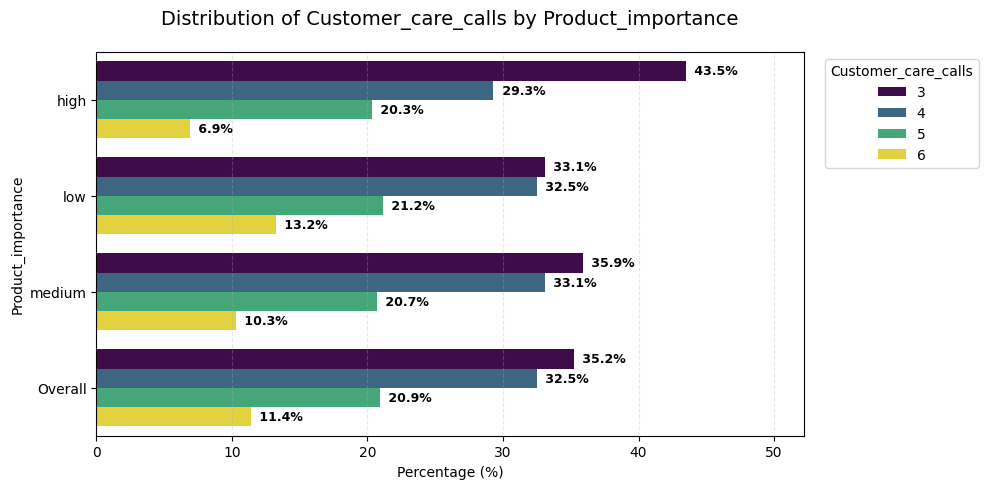

[✅ 이상치 없음] 'Customer_rating': 모든 Product_importance에서 고른 분포를 보입니다.

[🚨 이상치 발견] 'Prior_purchases' 특성은 Product_importance별로 유의미한 차이가 있습니다.


Prior_purchases,2,3,4,5,6
Product_importance,,,,,
high,199 (25.9%),309 (40.2%),113 (14.7%),42 (5.5%),105 (13.7%)
low,949 (22.5%),1486 (35.3%),887 (21.0%),574 (13.6%),318 (7.5%)
medium,894 (23.4%),1387 (36.3%),723 (18.9%),411 (10.8%),402 (10.5%)
Overall,2042 (23.2%),3182 (36.2%),1723 (19.6%),1027 (11.7%),825 (9.4%)


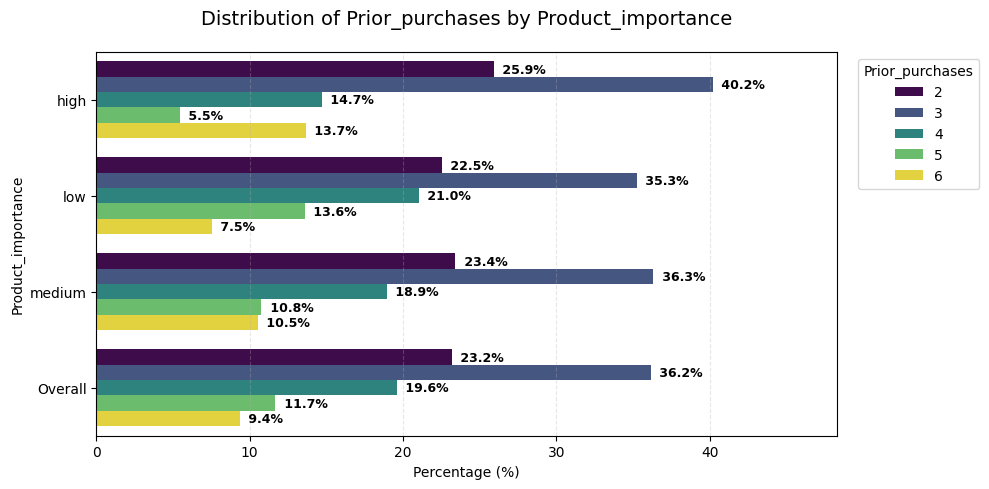

[✅ 이상치 없음] 'Gender': 모든 Product_importance에서 고른 분포를 보입니다.


In [358]:
summarize_categorical_with_plots(train_df, 'Product_importance', cat_cols, threshold=5.0)

[✅ 통과] 'Cost_of_the_Product': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Discount_offered': 그룹별 평균 차이가 미미합니다.

[🚨 차이 발견] 'Weight_in_gms' 특성은 Product_importance별로 평균 차이가 있습니다.


,count,mean,std,min,25%,50%,75%,max
Product_importance,,,,,,,,
high,768.0,4008.498698,1474.420311,1007.0,2868.25,4402.0,5195.50,6000.0
low,4214.0,3474.928334,1669.890264,1001.0,1714.00,3996.0,4986.75,5999.0
medium,3817.0,3727.875033,1605.159900,1001.0,1936.00,4212.0,5082.00,7846.0


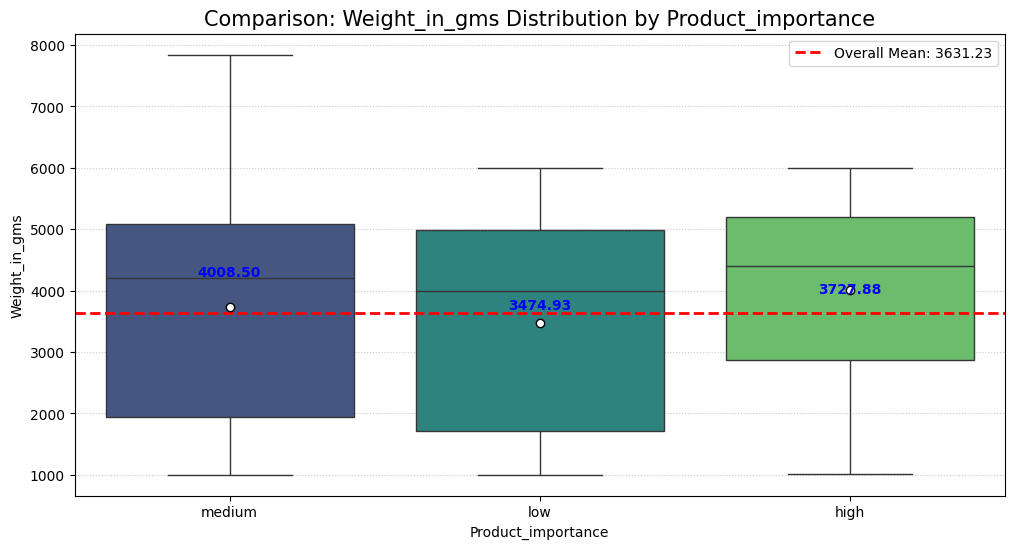

In [359]:
summarize_numeric_with_plots(train_df, 'Product_importance', num_cols, threshold=0.1)

In [366]:
copy_df = train_df.copy()[['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms', 'Product_importance', 'Reached.on.Time_Y.N']]
copy_df['Value_density'] = copy_df['Cost_of_the_Product'] / copy_df['Weight_in_gms']
# 더 풍부한 인사이트를 위한 코드 제안
result = copy_df.groupby('Product_importance').agg({
    'Value_density': 'mean',
    'Cost_of_the_Product': 'mean',
    'Weight_in_gms': 'mean',
    'Discount_offered': 'mean',
    'Reached.on.Time_Y.N': 'mean' # 지연율 확인
})
print(result)

                    Value_density  Cost_of_the_Product  Weight_in_gms  \
Product_importance                                                      
high                     0.062151           202.497396    4008.498698   
low                      0.085479           212.250356    3474.928334   
medium                   0.075860           209.556196    3727.875033   

                    Discount_offered  Reached.on.Time_Y.N  
Product_importance                                         
high                       14.041667             0.648438  
low                        13.275748             0.597532  
medium                     13.331936             0.585276  


중요도 high: 무게가 가장 무겁고, 가치밀도는 낮으며, 지연율이 가장 높음. 
할인율이 문제?

In [369]:
copy_df['Discount_rate'] = (copy_df['Discount_offered'] / copy_df['Cost_of_the_Product'])*100

result = copy_df.groupby('Product_importance').agg({
    'Value_density': 'mean',
    'Cost_of_the_Product': 'mean',
    'Weight_in_gms': 'mean',
    'Discount_offered': 'mean',
    'Discount_rate': 'mean',
    'Reached.on.Time_Y.N': 'mean' # 지연율 확인
})
print(result)

                    Value_density  Cost_of_the_Product  Weight_in_gms  \
Product_importance                                                      
high                     0.062151           202.497396    4008.498698   
low                      0.085479           212.250356    3474.928334   
medium                   0.075860           209.556196    3727.875033   

                    Discount_offered  Discount_rate  Reached.on.Time_Y.N  
Product_importance                                                        
high                       14.041667       7.486354             0.648438  
low                        13.275748       6.952706             0.597532  
medium                     13.331936       6.987751             0.585276  


중요도가 높을수록 할인율도 높음을 알 수 있으나 그 차이가 1%를 넘지 않음을 알 수 있다.

결론: 중요도가 높을수록 배송효율이 좋지 않은 - 부피가 크고 값이 싼- 물품임을 알 수 있다.

#### 7. Gender

In [ ]:
summarize_categorical_with_plots(train_df, 'Gender', cat_cols, threshold=5.0)

[✅ 이상치 없음] 'Warehouse_block': 모든 Gender에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Mode_of_Shipment': 모든 Gender에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_care_calls': 모든 Gender에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Customer_rating': 모든 Gender에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Prior_purchases': 모든 Gender에서 고른 분포를 보입니다.
[✅ 이상치 없음] 'Product_importance': 모든 Gender에서 고른 분포를 보입니다.


In [ ]:
summarize_numeric_with_plots(train_df, 'Gender', num_cols, threshold=0.1)

[✅ 통과] 'Cost_of_the_Product': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Discount_offered': 그룹별 평균 차이가 미미합니다.
[✅ 통과] 'Weight_in_gms': 그룹별 평균 차이가 미미합니다.


### 8. 'Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms'
수치형은 산점도로 확인

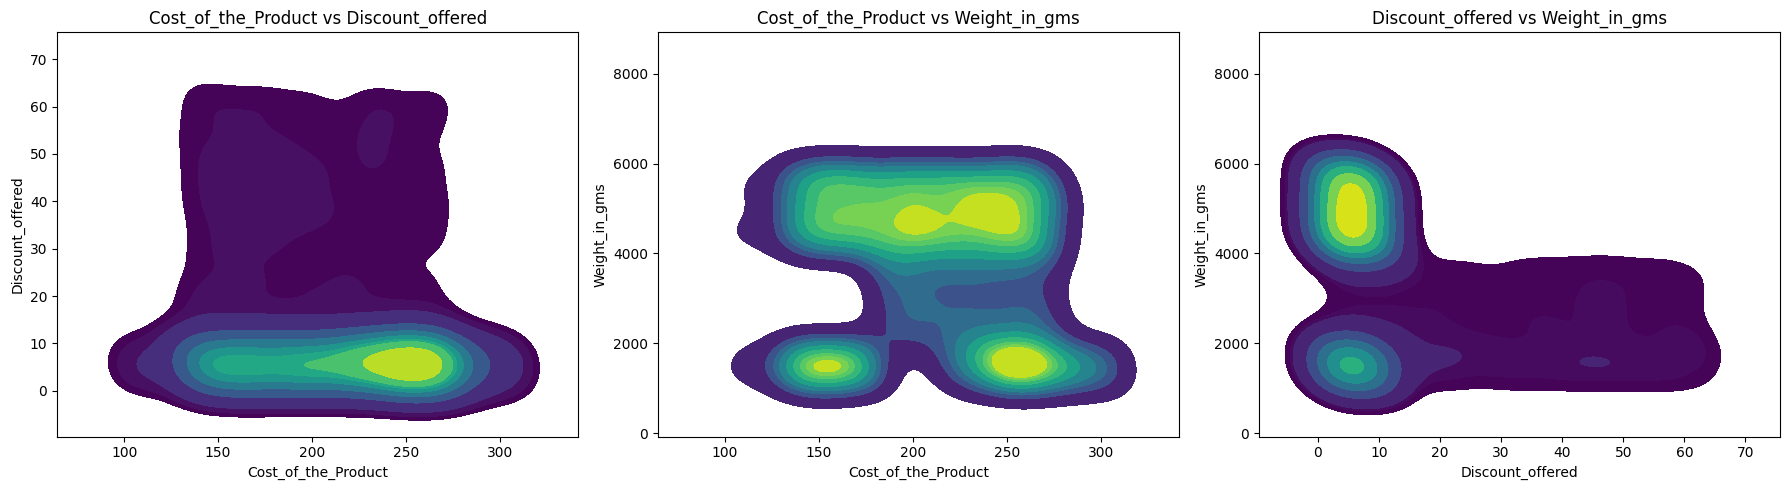

In [370]:
# 1행 3열의 레이아웃 설정
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 가격 vs 할인액
sns.kdeplot(data=train_df, x=num_cols[0], y=num_cols[1], ax=axes[0],fill=True, cmap='viridis')
axes[0].set_title(f'{num_cols[0]} vs {num_cols[1]}')

# 2. 가격 vs 무게
sns.kdeplot(data=train_df, x=num_cols[0], y=num_cols[2], ax=axes[1], fill=True, cmap='viridis')
axes[1].set_title(f'{num_cols[0]} vs {num_cols[2]}')

# 3. 할인액 vs 무게
sns.kdeplot(data=train_df, x=num_cols[1], y=num_cols[2], ax=axes[2], fill=True, cmap='viridis')
axes[2].set_title(f'{num_cols[1]} vs {num_cols[2]}')

plt.tight_layout()
plt.show()

In [ ]:
# 할인액 > 10인 구간에서 지연율 
print(train_df.loc[train_df['Discount_offered']==10][target].mean())
print(train_df.loc[train_df['Discount_offered']>10][target].mean())

0.4632352941176471
1.0


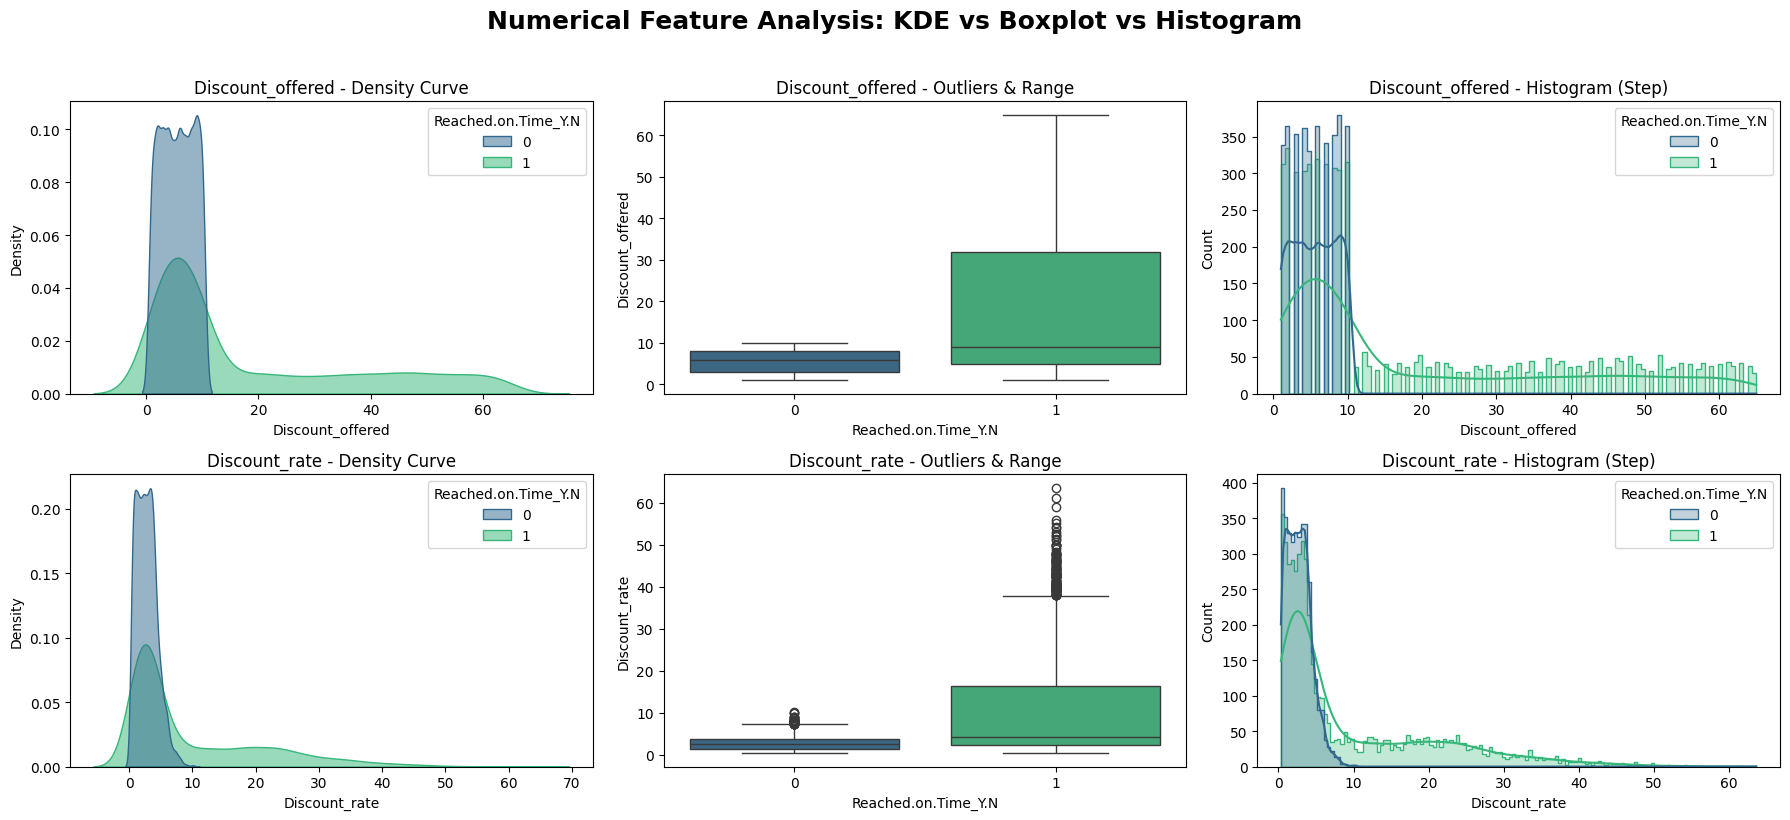

In [ ]:
# 할인액과 할인율 비교 -> 할인액이 더 나은 지표
plot_numeric_analysis(copy_df, ['Discount_offered', 'Discount_rate'], target)

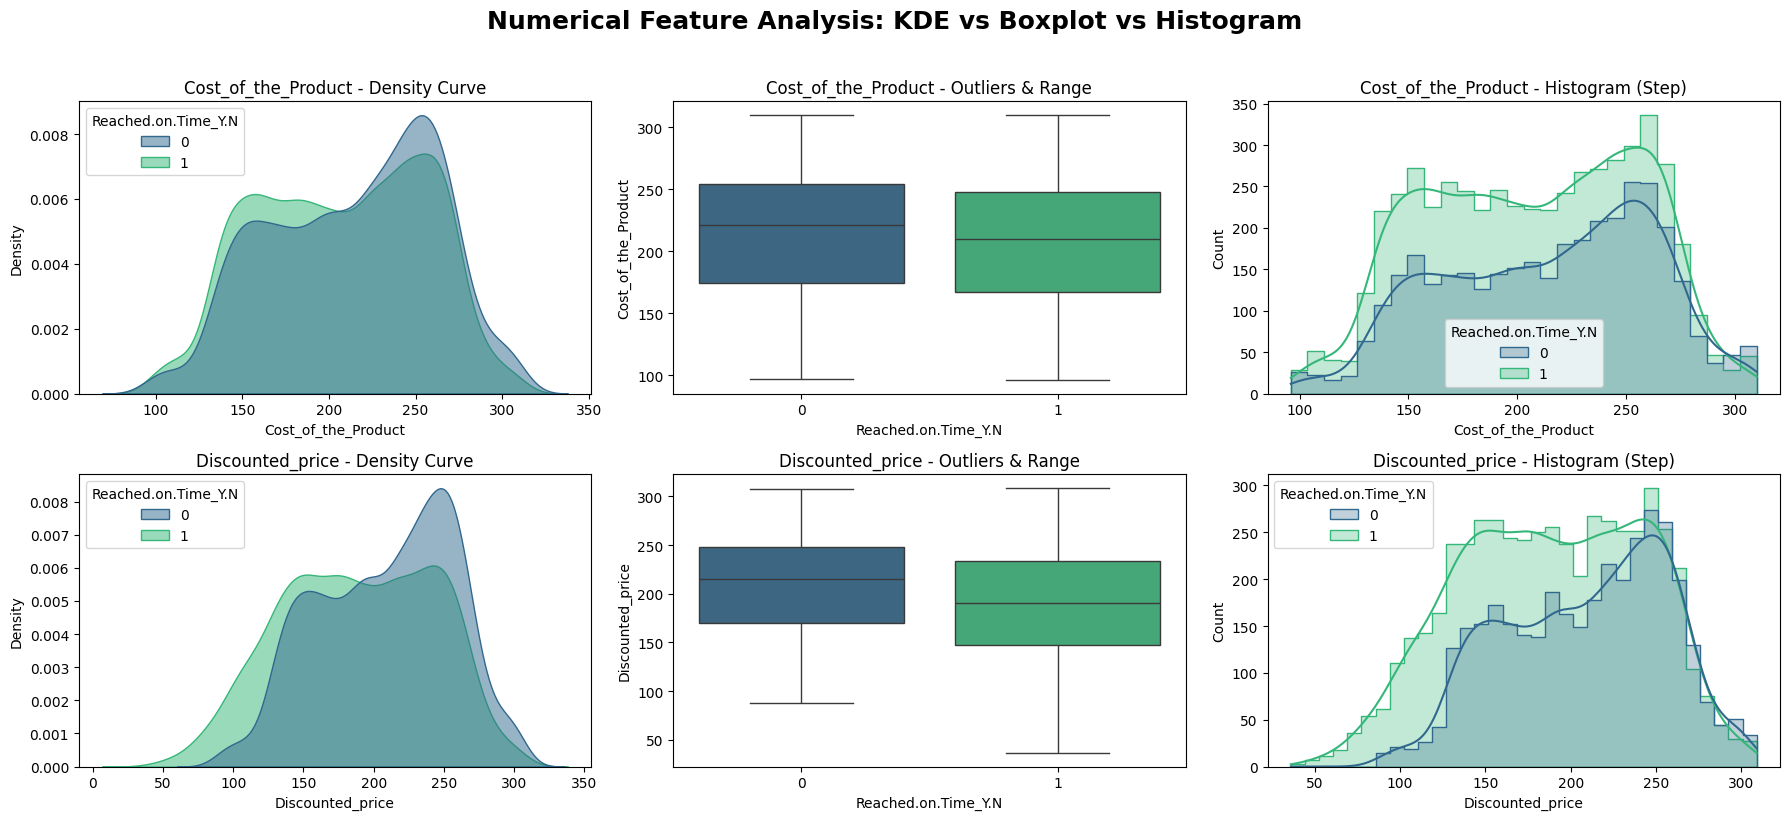

In [ ]:
# 원가와 실구매가 비교 -> 실구매가가 더 나은 지표
copy_df['Discounted_price'] = copy_df['Cost_of_the_Product'] - copy_df['Discount_offered']
plot_numeric_analysis(copy_df, ['Cost_of_the_Product', 'Discounted_price'], target)

## Feature engineering

In [ ]:
# 꼬임 방지를 위해 새로 지정
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')
target = 'Reached.on.Time_Y.N'
train_df.info()

### 새로운 파생 변수
1. 

In [ ]:
def apply_feature_engineering(df):
    # 1. Discount_Group 생성
    df['Discount_Group'] = (df['Discount_offered'] > 10).astype(int)
    
    # 2. Weight_Category 생성
    bins = [0, 2000, 4000, float('inf')]
    labels = ['light', 'medium', 'heavy']
    # 'Weight_Category' 생성 후 바로 숫자로 인코딩 (Ordinal)
    df['Weight_Category'] = pd.cut(df['Weight_in_gms'], bins=bins, labels=labels)
    # 모델 입력을 위해 숫자로 변환 (light:0, medium:1, heavy:2)
    df['Weight_Category'] = df['Weight_Category'].map({'light': 0, 'medium': 1, 'heavy': 2}).astype(int)
    
    # 3. 가치밀도(무게 대비 가격) 생성
    df['log_Value_density'] = np.log(df['Cost_of_the_Product'] / df['Weight_in_gms'])
    
    # 4. Product_importance: Label Encoding (순서가 있으므로 수동 매핑)
    importance_map = {'low': 0, 'medium': 1, 'high': 2}
    df['Product_importance'] = df['Product_importance'].map(importance_map)

    # 5. prior purchase 6이상 묶기
    df['Prior_purchases'] = df['Prior_purchases'].clip(upper=6)

    # 6. customer care call 범주 정리
    df.loc[df['Customer_care_calls'] >= 6, 'Customer_care_calls'] = 6
    df.loc[df['Customer_care_calls'] <= 3, 'Customer_care_calls'] = 3

   
    
    # 창고별 배송수단 조합 (예: 'A_Flight', 'F_Ship')
    # 단순 결합만으로도 특정 창고+수단 조합의 지연 패턴을 포착할 수 있습니다.
    df['Wh_Shipment_Combo'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)
    
    # 모델 학습을 위해 범주형을 숫자로 매핑 (Label Encoding과 유사)
    # AutoGluon을 쓰신다면 문자열 그대로 두어도 되지만, Scikit-learn 모델을 위해 숫자로 변환합니다.
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['Wh_Shipment_Combo'] = le.fit_transform(df['Wh_Shipment_Combo']) + 1

    return df

# 각각의 데이터셋에 적용
train_df = apply_feature_engineering(train_df)
test_df = apply_feature_engineering(test_df)


In [ ]:
drop_columns = ["ID", "Gender", "Discount_offered", "Weight_in_gms",'Warehouse_block', 'Customer_rating' ]
train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns, axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. One-Hot Encoding (Warehouse_block, Mode_of_Shipment)
# drop_first=True를 통해 다중공선성을 방지합니다.
train_df = pd.get_dummies(train_df, columns=['Mode_of_Shipment'])
test_df = pd.get_dummies(test_df, columns=['Mode_of_Shipment'])

# 2. Scaling 대상 컬럼 선정
# 새로 만든 log_rel_price와 기존 수치형 변수들을 포함합니다.
scale_cols = train_df.select_dtypes(include=['number']).columns.drop('Reached.on.Time_Y.N').tolist()

scaler = StandardScaler()

# 중요: fit은 오직 train_df에만 수행합니다!
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])

# test와 eval은 transform만 수행하여 데이터 누수를 차단합니다.
test_df[scale_cols] = scaler.transform(test_df[scale_cols])